# Import packages

In [3]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import logging
from functools import partial
import holoviews as hv
hv.extension('bokeh')
import matplotlib.pylab as plt

import logging

logging.basicConfig(level=logging.INFO)

Output hidden; open in https://colab.research.google.com to view.

# Custom functions

In [2]:
n = 100
m = 200
np.random.seed(1)
A = np.random.randn(m, n)

STOP_PARAM = 10 ** -5
ALPHA = 0.25
BETA = 0.8


## region Question1
def obj(x, a):
    """
    x.shape = (n,1)
    """
    out = -np.log((1 - a.dot(x))).sum() - np.log((1 - x ** 2)).sum()
    # logger.info("obj:\t")
    return out


def grad(x, a):
    return a.T.dot(1 / (1 - a.dot(x))) + 2 * x / (1 - x ** 2)


def hess(x, a):
    return a.T.dot(np.diag(1 / ((1 - a.dot(x)) ** 2).squeeze())).dot(a) + np.diag(
        (1 / ((1 - x) ** 2) + 1 / ((1 + x) ** 2)).squeeze())


def is_in_domain(x, a):
    if not (a.dot(x) <= 1).all() or not (np.abs(x) <= 1).all():
        return False
    return True


def backtracking(obj_func, x, step_size, grad, is_valid_x_func
                 , alpha: float = 0.25, beta: float = 0.8):
    """
    x.shape = step_size.shape = grad.shape = (n,1)
    """
    t = 1
    while t > beta * t:
        if not is_valid_x_func(x + t * step_size):
            t *= beta
            continue
        elif obj_func(x + t * step_size) < obj_func(x) + alpha * t * grad.T.dot(step_size).squeeze():
            break
        t *= beta
    return t


def gradient_decent(obj_func, grad_func, in_domain_func, x0, logger, max_itr=10 ** 4):
    x_itr = x0
    fx = [obj_func(x0)]
    for k in range(max_itr):

        grad_itr = grad_func(x_itr)
        if np.linalg.norm(grad_itr) <= STOP_PARAM:
            logger.info(f"itr:{k}:early stopping!")
            break

        # get step size
        step_size_itr = -grad_itr

        # line search
        t_itr = backtracking(obj_func, x_itr, step_size_itr, grad_itr, in_domain_func, ALPHA, BETA)

        # GD update
        x_itr += t_itr * step_size_itr
        fx += [obj_func(x_itr)]

        logger.info(f"itr:{k}\tmean_step_size:{t_itr * step_size_itr.mean()}\tobj_value:{fx[-1]}")

    return x_itr, fx


def newton_decent(obj_func, grad_func, in_domain_func, hess_func, tol, x0, logger, max_itr=10 ** 4):
    x_itr = x0
    fx = [obj_func(x0)]
    for k in range(max_itr):

        grad_itr = grad_func(x_itr)
        hess_itr = hess_func(x_itr)

        # compute newton step and decrement
        step_size_itr = -np.linalg.inv(hess_itr).dot(grad_itr)
        newton_decrement = grad_itr.T.dot(-step_size_itr)

        if newton_decrement / 2 <= tol:
            logger.info(f"itr:{k}:early stopping!")
            break

        # line search
        t_itr = backtracking(obj_func, x_itr, step_size_itr, grad_itr, in_domain_func, ALPHA, BETA)

        # GD update
        x_itr += t_itr * step_size_itr
        fx += [obj_func(x_itr)]

        logger.info(f"itr:{k}\tmean_step_size:{t_itr * step_size_itr.mean()}\tobj_value:{fx[-1]}")

    return x_itr, fx


def hessian(x, a):
    pass


## endregion

## region Question2
def syntesize_waterflow_data():
    np.random.seed(0)

    n = 10;
    m = 20;
    k = 3  # (edges 1,2,3 are producers and 4 to 10 are consumers)
    alpha = 15
    Rmin = 0.5 * np.ones(shape=(m, 1))
    Rmax = 2.5 * np.ones(shape=(m, 1))
    Smax = 5 * np.ones(shape=(k, 1))
    L = 5 * np.random.rand(m, 1) + 5  # pipe length

    N = 10  # 10 consumption scenarios
    C = 2 * np.random.rand(n - k, N)  # C(:,i) = c^(i) Consumption vectors

    # altitudes
    h = np.random.rand(n, 1)
    h = np.sort(h, axis=0)[::-1]

    edges = np.array([[1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 7, 8, 9],
                      [2, 3, 4, 6, 3, 4, 5, 6, 6, 7, 8, 7, 7, 8, 8, 9, 9, 10, 10, 10]]).T
    edges -= 1

    # incidence matrix
    A = np.zeros(shape=(n, m))
    for j in range(edges.shape[0]):
        A[edges[j, 0], j] = -1
        A[edges[j, 1], j] = 1

    return alpha, Rmin, Rmax, Smax, C, L, h, A, n, m, k, N


## endregion

# region Question 3 - Flux

def synt_flux_fba_data():
    # data file for flux balance analysis in systems biology
    # From Segre, Zucker et al "From annotated genomes to metabolic flux
    # models and kinetic parameter fitting" OMICS 7 (3), 301-316.

    # Stoichiometric matrix
    #	M1	M2	M3	M4	M5	M6
    S = np.array([
        [1, 0, 0, 0, 0, 0],  # R1:  extracellular -->  M1
        [-1, 1, 0, 0, 0, 0],  # R2:  M1 -->  M2
        [-1, 0, 1, 0, 0, 0],  # R3:  M1 -->  M3
        [0, -1, 0, 2, -1, 0],  # R4:  M2 + M5 --> 2 M4
        [0, 0, 0, 0, 1, 0],  # R5:  extracellular -->  M5
        [0, -2, 1, 0, 0, 1],  # R6:  2 M2 -->  M3 + M6
        [0, 0, -1, 1, 0, 0],  # R7:  M3 -->  M4
        [0, 0, 0, 0, 0, -1],  # R8:  M6 --> extracellular
        [0, 0, 0, -1, 0, 0],  # R9:  M4 --> cell biomass
    ]).T;

    m, n = S.shape;
    vmax = np.array([
        10.10,  # R1:  extracellular -->  M1
        100,  # R2:  M1 -->  M2
        5.90,  # R3:  M1 -->  M3
        100,  # R4:  M2 + M5 --> 2 M4
        3.70,  # R5:  extracellular -->  M5
        100,  # R6:  2 M2 --> M3 + M6
        100,  # R7:  M3 -->  M4
        100,  # R8:  M6 -->  extracellular
        100,  # R9:  M4 -->  cell biomass
    ])
    return S, vmax, m, n


# endregion

# region Question 4 - Online Advertising
def synt_online_ad_displays():
    # data for online ad display problem
    np.random.seed(0)
    n = 100  # number of ads
    m = 30  # number of contracts
    T = 60  # number of periods

    I = 10 * np.random.rand(T, 1)  # number of impressions in each period (dim = T X 1)
    R = np.random.rand(n, T)  # revenue rate for each period and ad (dim = n X T)
    q = T / n * 50 * np.random.rand(m, 1)  # contract target number of impressions
    p = np.random.rand(m, 1)  # penalty rate for shortfall

    # one column per contract. 1's at the periods to be displayed (dim = T X m)
    Tcontr = (np.random.rand(T, m) > .8)

    # one column per contract. 1's at the ads to be displayed (dim = n X m)
    Acontr = np.zeros((n, m))
    for i in range(n):
        contract = int(np.floor(m * np.random.rand()))
        Acontr[i, contract] = 1

    return Acontr, Tcontr, I, R, q, p, n, m, T


## endregion

# region Question 5 - Rank aggregation problem

def synt_rank_aggr_data():
    # Data file for rank aggregation problem

    # The data was generated using the following code:

    # !!WARNING!! MATLAB CODE

    # rand('state',0);
    # numobjects=50;
    # numpref=1000;
    #
    # true_ranking=randperm(numobjects);      %object ids sorted according to their rank
    # map_object_to_ranking(true_ranking)=[1:numobjects]; %ranks sorted according to object id
    # objects=randint(numpref,2,numobjects)+1;  %pairs of objects in the preferences
    #
    # %remove pairs with the same object
    # pos=find(objects(:,1)==objects(:,2));
    # while(~isempty(pos))
    #     objects(pos,:)=randint(length(pos),2,numobjects)+1;
    #     pos=find(objects(:,1)==objects(:,2));
    # end
    #
    # %coherent preferences
    # for i=1:numpref*.9
    #     ranking1=map_object_to_ranking(objects(i,1));
    #     ranking2=map_object_to_ranking(objects(i,2));
    #     if ranking1 < ranking2
    #         preferences(i,:)=[objects(i,2) objects(i,1)];
    #     elseif ranking1 > ranking2
    #         preferences(i,:)=[objects(i,1) objects(i,2)];
    #     end
    # end
    # %incoherent measurements
    # for j=i+1:numpref
    #     ranking1=map_object_to_ranking(objects(j,1));
    #     ranking2=map_object_to_ranking(objects(j,2));
    #     if ranking1 < ranking2
    #         preferences(j,:)=[objects(j,1) objects(j,2)];
    #     elseif ranking1 > ranking2
    #         preferences(j,:)=[objects(j,2) objects(j,1)];
    #     end
    # end
    #
    # %scramble measurements
    # preferences=preferences(randperm(numpref),:);

    #!!WARNING!! MATLAB CODE

    n = 50
    m = 1000

    # one preference per row
    # first column is i; second column is j
    preferences = np.array([
        [40, 7],
        [35, 22],
        [46, 50],
        [32, 8],
        [47, 26],
        [5, 26],
        [28, 10],
        [41, 30],
        [34, 21],
        [46, 33],
        [3, 44],
        [22, 50],
        [46, 8],
        [34, 39],
        [32, 48],
        [1, 39],
        [1, 28],
        [41, 31],
        [11, 21],
        [37, 42],
        [26, 5],
        [32, 30],
        [2, 27],
        [43, 46],
        [34, 47],
        [45, 44],
        [37, 9],
        [14, 23],
        [23, 2],
        [27, 31],
        [37, 33],
        [38, 31],
        [5, 10],
        [16, 39],
        [17, 50],
        [27, 8],
        [1, 49],
        [2, 15],
        [44, 48],
        [35, 30],
        [41, 10],
        [32, 23],
        [48, 50],
        [37, 4],
        [35, 36],
        [33, 16],
        [19, 38],
        [1, 38],
        [34, 47],
        [22, 25],
        [27, 49],
        [36, 19],
        [46, 30],
        [45, 22],
        [41, 24],
        [19, 21],
        [10, 48],
        [41, 9],
        [1, 41],
        [40, 48],
        [1, 48],
        [36, 31],
        [15, 21],
        [38, 10],
        [37, 49],
        [50, 8],
        [1, 35],
        [41, 35],
        [14, 15],
        [6, 33],
        [44, 26],
        [47, 49],
        [41, 31],
        [11, 2],
        [20, 47],
        [5, 11],
        [34, 7],
        [3, 4],
        [38, 46],
        [1, 26],
        [47, 10],
        [7, 26],
        [37, 34],
        [28, 46],
        [11, 16],
        [9, 28],
        [18, 33],
        [5, 12],
        [35, 49],
        [18, 25],
        [37, 21],
        [7, 21],
        [10, 19],
        [1, 32],
        [9, 26],
        [47, 2],
        [13, 30],
        [20, 21],
        [18, 12],
        [32, 28],
        [2, 5],
        [35, 21],
        [12, 7],
        [46, 48],
        [45, 31],
        [24, 36],
        [34, 3],
        [47, 21],
        [20, 18],
        [9, 29],
        [37, 24],
        [10, 21],
        [26, 40],
        [38, 30],
        [23, 15],
        [14, 28],
        [5, 42],
        [7, 31],
        [4, 36],
        [40, 24],
        [10, 31],
        [5, 43],
        [41, 45],
        [37, 26],
        [41, 27],
        [7, 33],
        [5, 30],
        [39, 31],
        [41, 27],
        [17, 31],
        [47, 29],
        [49, 27],
        [36, 26],
        [2, 42],
        [17, 26],
        [13, 49],
        [9, 15],
        [35, 29],
        [41, 3],
        [32, 42],
        [5, 27],
        [12, 11],
        [17, 34],
        [29, 39],
        [19, 8],
        [5, 50],
        [17, 12],
        [46, 30],
        [20, 40],
        [1, 17],
        [1, 45],
        [20, 11],
        [28, 9],
        [11, 15],
        [14, 41],
        [17, 2],
        [23, 16],
        [23, 14],
        [45, 4],
        [9, 8],
        [20, 38],
        [23, 11],
        [13, 28],
        [28, 39],
        [34, 14],
        [40, 11],
        [3, 30],
        [10, 49],
        [32, 27],
        [7, 26],
        [20, 4],
        [33, 10],
        [37, 9],
        [25, 49],
        [3, 27],
        [23, 27],
        [28, 10],
        [22, 31],
        [16, 50],
        [18, 14],
        [3, 30],
        [1, 3],
        [34, 35],
        [35, 21],
        [13, 25],
        [48, 21],
        [37, 32],
        [28, 24],
        [43, 44],
        [36, 42],
        [27, 10],
        [48, 29],
        [1, 10],
        [14, 26],
        [1, 11],
        [48, 2],
        [12, 28],
        [32, 33],
        [12, 44],
        [1, 33],
        [6, 42],
        [37, 38],
        [49, 31],
        [1, 24],
        [49, 29],
        [7, 24],
        [43, 16],
        [20, 42],
        [33, 21],
        [13, 9],
        [45, 11],
        [29, 26],
        [9, 40],
        [14, 8],
        [22, 15],
        [20, 22],
        [32, 48],
        [20, 45],
        [5, 39],
        [34, 41],
        [47, 49],
        [19, 39],
        [5, 29],
        [49, 44],
        [13, 2],
        [48, 34],
        [17, 38],
        [12, 4],
        [46, 2],
        [13, 24],
        [14, 24],
        [6, 29],
        [24, 12],
        [32, 38],
        [45, 22],
        [44, 37],
        [7, 16],
        [17, 44],
        [9, 38],
        [2, 30],
        [6, 25],
        [13, 25],
        [27, 13],
        [7, 50],
        [24, 13],
        [7, 10],
        [25, 5],
        [37, 10],
        [38, 22],
        [13, 23],
        [38, 33],
        [47, 15],
        [28, 16],
        [34, 12],
        [1, 40],
        [5, 21],
        [13, 50],
        [4, 5],
        [43, 4],
        [45, 1],
        [45, 32],
        [6, 20],
        [39, 27],
        [32, 35],
        [18, 9],
        [41, 8],
        [33, 49],
        [28, 7],
        [12, 48],
        [41, 29],
        [36, 30],
        [45, 4],
        [41, 32],
        [4, 48],
        [46, 33],
        [41, 8],
        [19, 16],
        [6, 28],
        [13, 10],
        [4, 40],
        [25, 16],
        [14, 8],
        [34, 42],
        [1, 19],
        [30, 31],
        [14, 50],
        [42, 12],
        [11, 33],
        [35, 33],
        [36, 39],
        [3, 21],
        [35, 50],
        [23, 26],
        [23, 44],
        [37, 32],
        [38, 2],
        [10, 21],
        [5, 10],
        [38, 2],
        [3, 50],
        [20, 31],
        [43, 20],
        [3, 29],
        [4, 27],
        [22, 8],
        [40, 29],
        [11, 8],
        [7, 31],
        [11, 42],
        [40, 36],
        [1, 15],
        [20, 7],
        [13, 2],
        [42, 36],
        [17, 49],
        [1, 22],
        [23, 12],
        [47, 13],
        [32, 43],
        [33, 37],
        [34, 33],
        [45, 6],
        [36, 50],
        [23, 4],
        [28, 43],
        [45, 31],
        [20, 43],
        [36, 39],
        [26, 3],
        [50, 42],
        [25, 1],
        [16, 22],
        [9, 16],
        [4, 22],
        [14, 4],
        [4, 29],
        [6, 3],
        [17, 48],
        [34, 28],
        [5, 45],
        [12, 16],
        [7, 29],
        [19, 24],
        [16, 27],
        [40, 44],
        [8, 50],
        [18, 32],
        [18, 20],
        [46, 22],
        [9, 47],
        [44, 27],
        [32, 13],
        [17, 19],
        [3, 19],
        [12, 28],
        [13, 28],
        [43, 44],
        [41, 10],
        [12, 24],
        [38, 7],
        [13, 41],
        [9, 26],
        [7, 29],
        [33, 32],
        [3, 33],
        [37, 12],
        [8, 28],
        [3, 7],
        [4, 48],
        [43, 26],
        [43, 35],
        [31, 5],
        [41, 33],
        [40, 11],
        [9, 12],
        [45, 23],
        [13, 29],
        [10, 39],
        [32, 24],
        [20, 6],
        [39, 24],
        [11, 21],
        [30, 31],
        [2, 26],
        [28, 16],
        [41, 9],
        [21, 45],
        [17, 37],
        [7, 30],
        [46, 25],
        [25, 1],
        [18, 37],
        [6, 2],
        [47, 8],
        [19, 16],
        [9, 2],
        [49, 39],
        [2, 47],
        [13, 19],
        [34, 23],
        [45, 25],
        [1, 28],
        [49, 33],
        [16, 29],
        [17, 23],
        [48, 29],
        [37, 50],
        [37, 29],
        [26, 49],
        [14, 8],
        [35, 36],
        [46, 31],
        [38, 15],
        [47, 46],
        [32, 4],
        [30, 50],
        [34, 15],
        [33, 14],
        [22, 15],
        [37, 45],
        [40, 21],
        [47, 38],
        [32, 48],
        [45, 14],
        [38, 8],
        [23, 3],
        [40, 22],
        [14, 44],
        [37, 47],
        [5, 44],
        [22, 42],
        [38, 20],
        [22, 39],
        [14, 19],
        [9, 16],
        [5, 33],
        [3, 37],
        [35, 39],
        [13, 25],
        [12, 41],
        [34, 3],
        [20, 14],
        [33, 49],
        [23, 19],
        [1, 39],
        [33, 25],
        [9, 23],
        [1, 50],
        [7, 31],
        [1, 12],
        [40, 15],
        [37, 19],
        [10, 24],
        [14, 16],
        [11, 8],
        [14, 4],
        [43, 36],
        [34, 44],
        [3, 7],
        [33, 8],
        [46, 40],
        [16, 27],
        [28, 2],
        [17, 31],
        [48, 15],
        [1, 2],
        [29, 39],
        [26, 7],
        [3, 27],
        [36, 21],
        [12, 35],
        [13, 10],
        [45, 36],
        [32, 31],
        [13, 31],
        [20, 7],
        [34, 47],
        [39, 49],
        [50, 39],
        [2, 25],
        [5, 22],
        [32, 16],
        [10, 19],
        [34, 49],
        [19, 49],
        [47, 19],
        [37, 29],
        [20, 15],
        [35, 31],
        [45, 49],
        [40, 29],
        [46, 16],
        [5, 29],
        [49, 25],
        [46, 50],
        [6, 24],
        [6, 35],
        [26, 30],
        [34, 13],
        [12, 39],
        [18, 24],
        [1, 32],
        [1, 36],
        [28, 35],
        [47, 44],
        [45, 8],
        [43, 35],
        [18, 35],
        [13, 35],
        [19, 15],
        [14, 27],
        [21, 5],
        [20, 4],
        [33, 26],
        [34, 42],
        [38, 46],
        [44, 15],
        [1, 41],
        [18, 11],
        [12, 7],
        [40, 10],
        [17, 13],
        [14, 33],
        [19, 16],
        [48, 42],
        [5, 12],
        [17, 11],
        [4, 25],
        [22, 24],
        [9, 27],
        [13, 15],
        [40, 50],
        [28, 49],
        [4, 17],
        [9, 29],
        [45, 21],
        [40, 2],
        [26, 39],
        [40, 2],
        [37, 49],
        [2, 12],
        [4, 27],
        [22, 8],
        [45, 50],
        [33, 19],
        [46, 15],
        [3, 30],
        [44, 15],
        [37, 36],
        [23, 32],
        [5, 40],
        [23, 15],
        [20, 28],
        [36, 8],
        [41, 44],
        [48, 24],
        [20, 41],
        [45, 35],
        [45, 47],
        [49, 12],
        [32, 39],
        [10, 21],
        [1, 41],
        [6, 47],
        [9, 50],
        [18, 12],
        [23, 46],
        [18, 49],
        [6, 16],
        [40, 50],
        [23, 16],
        [6, 16],
        [19, 48],
        [46, 19],
        [42, 8],
        [13, 27],
        [44, 31],
        [13, 12],
        [40, 48],
        [1, 13],
        [6, 42],
        [20, 32],
        [40, 22],
        [17, 4],
        [28, 50],
        [26, 42],
        [16, 39],
        [37, 39],
        [25, 36],
        [44, 24],
        [17, 49],
        [1, 44],
        [46, 43],
        [41, 18],
        [21, 13],
        [4, 24],
        [3, 24],
        [40, 16],
        [3, 15],
        [33, 42],
        [43, 19],
        [43, 42],
        [19, 2],
        [49, 42],
        [40, 11],
        [11, 3],
        [37, 40],
        [45, 18],
        [1, 36],
        [19, 2],
        [12, 48],
        [50, 39],
        [37, 48],
        [10, 21],
        [29, 26],
        [47, 38],
        [41, 16],
        [45, 42],
        [23, 29],
        [40, 16],
        [45, 50],
        [44, 15],
        [16, 7],
        [7, 21],
        [5, 39],
        [14, 10],
        [36, 39],
        [17, 40],
        [19, 27],
        [20, 25],
        [5, 48],
        [43, 40],
        [17, 5],
        [35, 26],
        [16, 42],
        [17, 9],
        [33, 39],
        [1, 46],
        [16, 27],
        [36, 17],
        [18, 16],
        [5, 23],
        [36, 49],
        [6, 7],
        [45, 48],
        [48, 18],
        [23, 26],
        [14, 25],
        [42, 23],
        [44, 42],
        [37, 41],
        [37, 24],
        [25, 24],
        [11, 3],
        [43, 50],
        [19, 30],
        [12, 8],
        [44, 31],
        [27, 15],
        [33, 15],
        [3, 21],
        [32, 44],
        [1, 25],
        [34, 10],
        [3, 2],
        [47, 44],
        [37, 44],
        [18, 42],
        [16, 50],
        [13, 36],
        [20, 8],
        [44, 48],
        [19, 2],
        [37, 41],
        [18, 8],
        [28, 44],
        [13, 32],
        [35, 25],
        [6, 32],
        [11, 49],
        [9, 39],
        [9, 33],
        [22, 49],
        [36, 11],
        [26, 25],
        [18, 31],
        [47, 42],
        [5, 45],
        [9, 47],
        [48, 50],
        [34, 48],
        [20, 19],
        [35, 26],
        [1, 42],
        [5, 42],
        [1, 35],
        [45, 36],
        [42, 48],
        [35, 19],
        [25, 43],
        [5, 40],
        [18, 21],
        [25, 1],
        [41, 21],
        [28, 48],
        [37, 43],
        [9, 32],
        [45, 21],
        [48, 2],
        [25, 21],
        [1, 49],
        [19, 26],
        [7, 27],
        [27, 3],
        [1, 32],
        [10, 15],
        [7, 43],
        [21, 42],
        [7, 30],
        [5, 49],
        [6, 10],
        [49, 30],
        [17, 45],
        [18, 37],
        [41, 42],
        [19, 49],
        [11, 10],
        [16, 21],
        [34, 4],
        [49, 42],
        [11, 29],
        [30, 23],
        [9, 14],
        [17, 35],
        [19, 31],
        [16, 22],
        [38, 21],
        [17, 33],
        [46, 33],
        [17, 4],
        [30, 24],
        [3, 23],
        [12, 11],
        [13, 20],
        [35, 33],
        [34, 50],
        [32, 8],
        [12, 50],
        [10, 31],
        [35, 30],
        [37, 30],
        [20, 26],
        [11, 24],
        [14, 10],
        [7, 17],
        [49, 31],
        [1, 21],
        [12, 19],
        [19, 29],
        [23, 36],
        [15, 26],
        [10, 31],
        [21, 38],
        [12, 7],
        [35, 21],
        [3, 48],
        [3, 30],
        [12, 38],
        [2, 39],
        [17, 22],
        [37, 33],
        [7, 36],
        [21, 34],
        [17, 24],
        [48, 25],
        [20, 50],
        [35, 42],
        [43, 15],
        [3, 22],
        [5, 42],
        [18, 46],
        [16, 40],
        [13, 20],
        [22, 24],
        [33, 29],
        [5, 26],
        [34, 36],
        [35, 29],
        [1, 10],
        [23, 11],
        [32, 42],
        [1, 8],
        [22, 31],
        [12, 33],
        [16, 41],
        [19, 31],
        [28, 16],
        [14, 30],
        [1, 24],
        [11, 48],
        [20, 31],
        [50, 15],
        [15, 8],
        [18, 11],
        [12, 15],
        [13, 33],
        [43, 30],
        [32, 36],
        [5, 41],
        [20, 24],
        [4, 49],
        [28, 50],
        [43, 36],
        [37, 6],
        [17, 41],
        [37, 39],
        [13, 7],
        [35, 21],
        [34, 11],
        [23, 4],
        [2, 9],
        [41, 23],
        [48, 25],
        [36, 24],
        [47, 46],
        [44, 25],
        [49, 32],
        [9, 23],
        [3, 31],
        [29, 27],
        [33, 48],
        [32, 1],
        [39, 27],
        [39, 50],
        [7, 15],
        [7, 49],
        [35, 21],
        [21, 42],
        [5, 41],
        [10, 22],
        [5, 3],
        [32, 43],
        [41, 30],
        [45, 34],
        [16, 44],
        [9, 42],
        [7, 25],
        [34, 23],
        [9, 3],
        [18, 10],
        [37, 45],
        [44, 30],
        [33, 34],
        [34, 29],
        [34, 5],
        [4, 29],
        [46, 15],
        [41, 8],
        [11, 3],
        [34, 36],
        [47, 48],
        [34, 26],
        [23, 21],
        [7, 31],
        [1, 27],
        [28, 29],
        [37, 19],
        [6, 35],
        [39, 34],
        [47, 25],
        [17, 29],
        [19, 22],
        [48, 22],
        [46, 24],
        [19, 25],
        [7, 36],
        [19, 31],
        [34, 32],
        [17, 47],
        [20, 32],
        [10, 22],
        [47, 19],
        [3, 35],
        [39, 22],
        [49, 41],
        [1, 32],
        [14, 44],
        [1, 42],
        [41, 44],
        [14, 40],
        [9, 15],
        [6, 11],
        [41, 42],
        [42, 34],
        [9, 44],
        [12, 19],
        [6, 42],
        [43, 24],
        [32, 21],
        [16, 39],
        [23, 29],
        [23, 16],
        [9, 25],
        [46, 27],
        [18, 20],
        [18, 17],
        [40, 46],
        [14, 24],
        [1, 9],
        [1, 25],
        [49, 15],
        [48, 21],
        [28, 38],
        [35, 39],
        [32, 33],
        [9, 10],
        [3, 35],
        [16, 50],
        [4, 24],
        [44, 17],
        [15, 31],
        [34, 21],
        [33, 27],
        [48, 32],
        [47, 50],
        [23, 15],
        [47, 26],
        [37, 39],
        [9, 19],
        [5, 25],
        [13, 25],
        [32, 22],
        [4, 10],
        [3, 44],
        [31, 18],
        [28, 19],
        [11, 28],
        [19, 25],
        [35, 30],
        [23, 48],
        [9, 16],
        [25, 8],
        [14, 22],
        [1, 41],
        [34, 3],
        [44, 30],
        [23, 9],
        [32, 2],
        [1, 11],
        [28, 37],
        [14, 38],
        [38, 42],
        [32, 42],
        [33, 25],
        [8, 24],
        [3, 4],
        [4, 39],
        [29, 25],
        [18, 20],
        [41, 47],
        [34, 15],
        [9, 4],
        [6, 22],
        [23, 48],
        [14, 48],
        [41, 49],
        [6, 32],
        [30, 50],
        [16, 45],
        [12, 36],
        [44, 50],
        [12, 16],
        [7, 48],
        [42, 8],
        [30, 42],
        [47, 43],
        [19, 30],
        [6, 26],
        [15, 24],
        [30, 15],
        [37, 4],
        [3, 38],
        [14, 26],
        [41, 11],
        [4, 42],
        [12, 32],
        [44, 20],
        [8, 24],
        [45, 29],
        [46, 25],
        [13, 50],
        [7, 19],
        [49, 30],
        [47, 4],
        [45, 19],
        [10, 48],
        [7, 48],
        [16, 27],
        [40, 21],
        [14, 47]])

    return preferences-1, n, m


# endregion

if "__main__" == __name__:
    mode = "ND"

    x0 = np.zeros((n, 1))
    obj_func = partial(obj, a=A)
    grad_func = partial(grad, a=A)
    in_domain_func = partial(is_in_domain, a=A)

    # gradient descent
    if mode == "GD":
        logger = logging.getLogger("grad_descent")
        # x = np.random.randn(n,1)
        gradient_decent(obj_func, grad_func
                        , in_domain_func, x0, logger=logger, max_itr=10 ** 4)

    # newton descent
    elif mode == "ND":
        hess_func = partial(hess, a=A)
        tol = 10 ** -6
        logger = logging.getLogger("NewtonDescent")
        newton_decent(obj_func, grad_func, in_domain_func
                      , hess_func, tol, x0, logger=logger, max_itr=10 ** 4)

# Question 1 - Gradient and Newton methods¶


## Gradient descent

In [4]:
n = 100
m = 200
np.random.seed(1)
logger = logging.getLogger("grad_descent")
A = np.random.randn(m,n)

STOP_PARAM = 10**-4
ALPHA = 0.01
BETA = 0.5

In [5]:
def obj(x, a):
    """
    x.shape = (n,1)
    """
    out = -np.log((1 - a.dot(x))).sum() - np.log((1 - x ** 2)).sum()
    # logger.info("obj:\t")
    return out


def grad(x, a):
    return a.T.dot(1 / (1 - a.dot(x))) + 2 * x / (1 - x ** 2)

def is_in_domain(x, a):
    if not (a.dot(x) <= 1).all() or not (np.abs(x)<=1).all():
        return False
    return True

def backtracking(obj_func, x, step_size, grad, is_valid_x_func
                 , alpha: float = 0.25, beta: float = 0.8):
    """
    x.shape = step_size.shape = grad.shape = (n,1)
    """
    t = 1
    while t > beta * t:
        if not is_valid_x_func(x + t * step_size):
            t *= beta
            continue
        elif obj_func(x + t * step_size) < obj_func(x) + alpha * t * grad.T.dot(step_size).squeeze():
            break
        t *= beta
    return t


def gradient_decent(obj_func, grad_func, in_domain_func, x0, logger, max_itr=10 ** 4):
    x_itr = x0
    fx = [obj_func(x0)]
    for k in range(max_itr):

        grad_itr = grad_func(x_itr)
        if np.linalg.norm(grad_itr) <= STOP_PARAM:
            logger.info(f"itr:{k}:early stopping!")
            break

        # get step size
        step_size_itr = -grad_itr

        # line search
        t_itr = backtracking(obj_func, x_itr, step_size_itr, grad_itr, in_domain_func, ALPHA, BETA)

        # GD update
        x_itr += t_itr * step_size_itr
        fx += [obj_func(x_itr)]

        logger.info(f"itr:{k}\tmean_step_size:{t_itr * step_size_itr.mean()}\tobj_value:{fx[-1]}")

    return x_itr, fx

In [7]:
# x = np.random.randn(n,1)
x0 = np.zeros((n,1))
obj_func = partial(obj, a=A)
grad_func = partial(grad, a=A)
in_domain_func = partial(is_in_domain, a=A)
logger = logging.getLogger("grad_descent")
x_prime, x_hist =\
        gradient_decent(obj_func, grad_func, in_domain_func, x0, logger=logger, max_itr=10 ** 4)

INFO:grad_descent:itr:0	mean_step_size:-0.0037515762004310766	obj_value:-41.814074761886815
INFO:grad_descent:itr:1	mean_step_size:-0.006318527500090896	obj_value:-73.09387663691727
INFO:grad_descent:itr:2	mean_step_size:-0.004099735189968884	obj_value:-79.5645596836999
INFO:grad_descent:itr:3	mean_step_size:-0.0013135195514500226	obj_value:-89.85848765552798
INFO:grad_descent:itr:4	mean_step_size:-0.004509730879514929	obj_value:-101.48082537586295
INFO:grad_descent:itr:5	mean_step_size:-0.0013853135879111026	obj_value:-102.53215431014092
INFO:grad_descent:itr:6	mean_step_size:-0.0014548732118283437	obj_value:-106.24958307470105
INFO:grad_descent:itr:7	mean_step_size:-0.0033300531279148483	obj_value:-116.07709296149993
INFO:grad_descent:itr:8	mean_step_size:-0.0014302528171652104	obj_value:-119.72320342732073
INFO:grad_descent:itr:9	mean_step_size:-0.0029704234527464335	obj_value:-123.61286401496085
INFO:grad_descent:itr:10	mean_step_size:-0.0016668656356262663	obj_value:-125.731196249

In [8]:
to_show=pd.DataFrame(x_hist - x_hist[-1],columns=["f(x_itr)-f(x_prime)"])
hv.Curve(to_show).options(width=800,logy=True)

:Curve   [index]   (f(x_itr)-f(x_prime))

## Newton method

In [9]:
logger = logging.getLogger("hess_descent")

In [11]:
def hess(x, a):
    return a.T.dot(np.diag(1/((1-a.dot(x))**2).squeeze())).dot(a) + np.diag((1/((1-x)**2) + 1/((1+x)**2)).squeeze())

def newton_decent(obj_func, grad_func, in_domain_func, hess_func, tol, x0, logger, max_itr=10 ** 4):
    x_itr = x0
    fx = [obj_func(x0)]
    for k in range(max_itr):

        grad_itr = grad_func(x_itr)
        hess_itr = hess_func(x_itr)

        # compute newton step and decrement
        step_size_itr = -np.linalg.inv(hess_itr).dot(grad_itr)
        newton_decrement = grad_itr.T.dot(-step_size_itr)

        if newton_decrement / 2 <= tol:
            logger.info(f"itr:{k}:early stopping!")
            break

        # line search
        t_itr = backtracking(obj_func, x_itr, step_size_itr, grad_itr, in_domain_func, ALPHA, BETA)

        # GD update
        x_itr += t_itr * step_size_itr
        fx += [obj_func(x_itr)]

        logger.info(f"itr:{k}\tmean_step_size:{t_itr * step_size_itr.mean()}\tobj_value:{fx[-1]}")

    return x_itr, fx

In [12]:
tol = 10**-6
x0 = np.zeros((n,1))
logger = logging.getLogger("NewtonDescent")
x_prime, x_hist =\
        newton_decent(obj_func, grad_func, in_domain_func, hess_func, tol, x0, logger=logger, max_itr=10 ** 4)

INFO:NewtonDescent:itr:0	mean_step_size:-0.016548716513128753	obj_value:-77.1067279910583
INFO:NewtonDescent:itr:1	mean_step_size:-0.02776822465682348	obj_value:-149.1895512332837
INFO:NewtonDescent:itr:2	mean_step_size:-0.020918872742011544	obj_value:-173.82437945034508
INFO:NewtonDescent:itr:3	mean_step_size:-0.023182789664068303	obj_value:-184.00542188882486
INFO:NewtonDescent:itr:4	mean_step_size:0.0026573559882045496	obj_value:-185.49279414656758
INFO:NewtonDescent:itr:5	mean_step_size:0.0009207794220105075	obj_value:-186.02799864488293
INFO:NewtonDescent:itr:6	mean_step_size:0.0006100945176348204	obj_value:-186.190380906921
INFO:NewtonDescent:itr:7	mean_step_size:0.0002638705827758474	obj_value:-186.20700249371868
INFO:NewtonDescent:itr:8	mean_step_size:2.7315349975942844e-05	obj_value:-186.20719170576498
INFO:NewtonDescent:itr:9:early stopping!


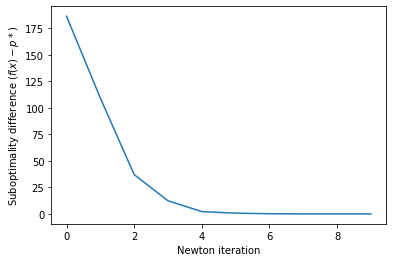

In [15]:
plt.plot(x_hist-x_hist[-1])
plt.xlabel("Newton iteration")
plt.ylabel(r"Suboptimality difference ($f(x)-p*$)")
plt.show()

## Q2 - Efficient solution of basic portfolio optimization problem


In [ ]:
# This is among the short course examples as well!

# Q3 - Sizing a gravity feed water supply network

In [16]:
alpha, Rmin, Rmax, Smax, C, L, h, A \
    ,num_nodes, num_edge, num_producers, num_scenarios = syntesize_waterflow_data()

In [18]:
z = cvx.Variable(shape = (num_edge,1), nonneg=True)
s = cvx.Variable(shape = (num_producers,num_scenarios),nonneg=True)
f = cvx.Variable(shape = (num_edge,num_scenarios),nonneg=True)
D1 = alpha * np.diag(-A.T.dot(h).flatten()) * np.diag(1/L.flatten())   

obj_func = cvx.Minimize(L.T * z)

constraints = [
    z >= Rmin**2,
    z <= Rmax**2,
]

loop_const = []
for k in range(num_scenarios):
    loop_const += [f[:,k] <= (D1*z).flatten()]
    loop_const += [A * f[:,k] == cvx.hstack([-s[:,k], C[:,k]])]
    loop_const += [s[:,k] <= Smax.flatten()]
constraints += loop_const 
prob = cvx.Problem(obj_func ,constraints)
sol = prob.solve(cvx.SCS)
print(f"optimal solution is: \t{sol}")
print(f"the optimal radii are\n{np.sqrt(z.value)}")

optimal solution is: 	325.745442984738
the optimal radii are
[[0.50001114]
 [0.50006763]
 [2.49997794]
 [1.26430382]
 [0.49994955]
 [0.50011182]
 [2.4237995 ]
 [0.49976785]
 [0.49996346]
 [1.48900908]
 [2.30352708]
 [2.49999471]
 [0.49997567]
 [0.49999239]
 [0.49993237]
 [1.83169115]
 [1.16302015]
 [2.03978109]
 [1.72299466]
 [0.50005732]]


# Question 3 - Flux balance analysis in systems biology

In [19]:
S, vmax, m, n = synt_flux_fba_data()

In [20]:
v = cvx.Variable(shape = (n,1), nonneg=True)
n_indicator = np.zeros(shape=(n,1))
n_indicator[-1] = 1
obj_func = cvx.Maximize(n_indicator.T * v)
constraints = [
    S * v == 0,
    v <= vmax[:,None]
] 
prob = cvx.Problem(obj_func ,constraints)
G_star = prob.solve()

In [21]:
print(f"maximum possible growth rate is - {v.value[-1][0]}")
print(f"reaction rate limits have nonzero optimal Lagrange -{np.argwhere(constraints[1].dual_value>0)[:,0]+1}")
print(f"reaction rate limits is "
      f"the maximum growth rate most sensitive to - {np.argmax(v.value)+1}")

maximum possible growth rate is - 13.54999999695169
reaction rate limits have nonzero optimal Lagrange -[1 2 3 4 5 6 7 8 9]
reaction rate limits is the maximum growth rate most sensitive to - 9


In [22]:
G_min = 0.2 * G_star

def is_essential(vmx, n=n, thresh=G_min, S=S):
    v = cvx.Variable(shape = (n,1), nonneg=True)
    n_indicator = np.zeros(shape=(n,1))
    n_indicator[-1] = 1
    obj_func = cvx.Maximize(n_indicator.T * v)
    constraints = [S * v == 0, v <= vmx[:,None]]
    prob = cvx.Problem(obj_func ,constraints)
    growth_rate = prob.solve()
    return growth_rate < thresh, growth_rate
    
for k in range(n):
    vm = vmax.copy()
    vm[k] = 0
    is_essential_flag ,gr = is_essential(vm, n, G_min)
    if is_essential_flag:
        print(f"{k+1} is essential, as growth rate is {gr}")

1 is essential, as growth rate is 2.714666078375953e-11
9 is essential, as growth rate is 2.994131326743363e-11


In [23]:
non_essential = np.arange(1,8)
X,Y = np.meshgrid(non_essential,non_essential)
possible_synt_lethal_pairs = zip(X.flatten(),Y.flatten())
possible_synt_lethal_pairs  = set([(x,y) if x>y else (y,x) 
     for x,y in filter(lambda x: x[0] != x[1],possible_synt_lethal_pairs)])

for cand in possible_synt_lethal_pairs:  
    vm = vmax.copy()
    vm[cand[0]] = 0; vm[cand[1]] = 0
    is_essential_flag ,gr = is_essential(vm, n, G_min)
    if is_essential_flag:
        print(f"{(cand[0]+1,cand[1]+1)} is lethal, as growth rate is {gr}")

(3, 2) is lethal, as growth rate is 4.907085642708621e-12
(7, 4) is lethal, as growth rate is 5.269891693136436e-11
(7, 5) is lethal, as growth rate is 1.0770330670932224e-11
(7, 2) is lethal, as growth rate is 1.7217180784949536e-10


# Question 4 - Online advertising displays

In [43]:
Acontr, Tcontr, I, R, q, p, n, m, T\
    = synt_online_ad_displays()

In [44]:
N = cvx.Variable(shape = (n,T))
s = cvx.Variable(shape = (m,1))
total_rev = R.flatten() * N.flatten()
total_penalty = p.T * cvx.pos(s)
obj_func = cvx.Maximize(total_rev - total_penalty )
constraints = [
    N >= 0,
    cvx.sum(N,axis=0)[:,None] == I,
    s == q - cvx.diag(Acontr.T * N * Tcontr)[:,None]
] 
prob = cvx.Problem(obj_func ,constraints)
sol = prob.solve()

In [45]:
print("What is the revenue associated with the optimal net profit")
print(f"ans:\t{sol}\n")
print("What is the total revenue payment associated with the optimal net profit?")
print(f"ans:\t{total_rev.value}\n")
print("What is the total penalty payment associated with the optimal net profit?")
print(f"ans:\t{total_penalty.value[0][0]}\n")

What is the revenue associated with the optimal net profit
ans:	269.27077223298

What is the total revenue payment associated with the optimal net profit?
ans:	288.5139111456517

What is the total penalty payment associated with the optimal net profit?
ans:	19.24313891264589



In [28]:
N = cvx.Variable(shape = (n, T))
total_rev = R.flatten() * N.flatten()
obj_func = cvx.Maximize(total_rev)
constraints = [
    N >= 0,
    cvx.sum(N,axis=0)[:,None] == I,
    # s == q - (N * Tcontr)[:,None]
] 
prob = cvx.Problem(obj_func ,constraints)
sol = prob.solve()

In [29]:
greedy_shortfall = q - cvx.diag(Acontr.T * N * Tcontr)[:,None]
greedy_profit = sol - p.T.dot(greedy_shortfall.value)
greedy_profit 
# greedy_revenue = cvx_optval;

print("What is the net profit if we were to display only the ad with the largest revenue per impression?")
print(f"ans:\t{greedy_profit[0][0]}\n")
print("What is the revenue if we were to display only the ad with the largest revenue per impression?")
print(f"ans:\t{sol}\n")
print("What is the total penalty if we were to display only the ad with the largest revenue per impression?")
print(f"ans:\t{p.T.dot(greedy_shortfall.value)[0][0]}\n")

What is the net profit if we were to display only the ad with the largest revenue per impression?
ans:	134.47338530243115

What is the revenue if we were to display only the ad with the largest revenue per impression?
ans:	306.4286725603062

What is the total penalty if we were to display only the ad with the largest revenue per impression?
ans:	171.95528725787506



# Question 5: Ranking by aggregating preferences

In [30]:
preferences, n, m = synt_rank_aggr_data()

In [31]:
mode = 'scenario_b'
r = cvx.Variable(shape = (n,1))
v = r[preferences[:,1]] + 1 - r[preferences[:,0]]
# v == r[preferences[:,1]] + 1 - r[preferences[:,0]] 
pref_violation = cvx.pos(v) # shape 1000X1
cost = cvx.sum_squares(pref_violation) if mode == 'scenario_a'\
    else cvx.sum(pref_violation) 
obj_func = cvx.Minimize(cost)
constraints = [
] 
prob = cvx.Problem(obj_func ,constraints)
sol = prob.solve()
sol

387.00000000048874

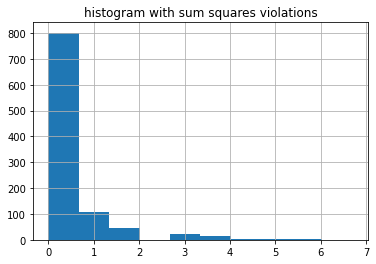

num of positive violations 235


In [32]:
ax = plt.gca()
pd.Series(np.squeeze(pref_violation.value)).hist(ax=ax,bins=10)
ax.set_title("histogram with sum squares violations")
plt.show()
print(f"num of positive violations {(v.value > 0.001).sum()}")

In [34]:
mode = 'scenario_a'
r = cvx.Variable(shape = (n,1))
v = r[preferences[:,1]] + 1 - r[preferences[:,0]]
# v == r[preferences[:,1]] + 1 - r[preferences[:,0]] 
pref_violation = cvx.pos(v) # shape 1000X1
cost = cvx.sum_squares(pref_violation) if mode == 'scenario_a'\
    else cvx.sum(pref_violation) 
obj_func = cvx.Minimize(cost)
constraints = [
] 
prob = cvx.Problem(obj_func ,constraints)
sol = prob.solve()
sol

523.0154272199974

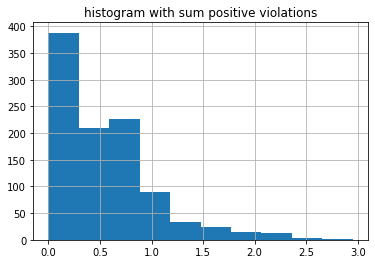

num of positive violations 781


In [35]:
ax = plt.gca()
pd.Series(np.squeeze(pref_violation.value)).hist(ax=ax, bins=10)
ax.set_title("histogram with sum positive violations")
plt.show()
print(f"num of positive violations {(v.value > 0.001).sum()}")

In [36]:
781-235

546